In [33]:
import pandas as pd
import numpy as np
import sklearn as sk
import pandas_profiling
import sys,os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas.api.types as ptypes
from numpy.random import choice

import random

## Can we leverage well-known feature selection strategies, such as Chi-squared ranking, toselect features that are more data-error robust?

Let's collect some statistics about every feature before corrupting the data. 


**Chi square** is a non-parametric test that is used to show association between two qualitative variables (like gender and eye color), while **correlation** (Pearson coefficient) is used to test the correlation between two quantitative variables (like heart rate and blood pressure)

In the given dataset we have only quantitative data 

In [2]:
df=pd.read_csv('./data.csv')
print(df.columns)
corr_matrix = df.corr().copy()
df.head()
df.shape

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object')


(569, 33)

In [70]:
df=pd.read_csv('./data.csv')
df['diagnosis'] =df['diagnosis'].apply(lambda x: 1 if x =="M" else 0)
y = df['diagnosis']

X = df.drop(['diagnosis','id','Unnamed: 32'],axis=1)
feature_cols = X.columns.to_list()

In [71]:
feature_stats = X.describe().T[['mean','std','max','min']]


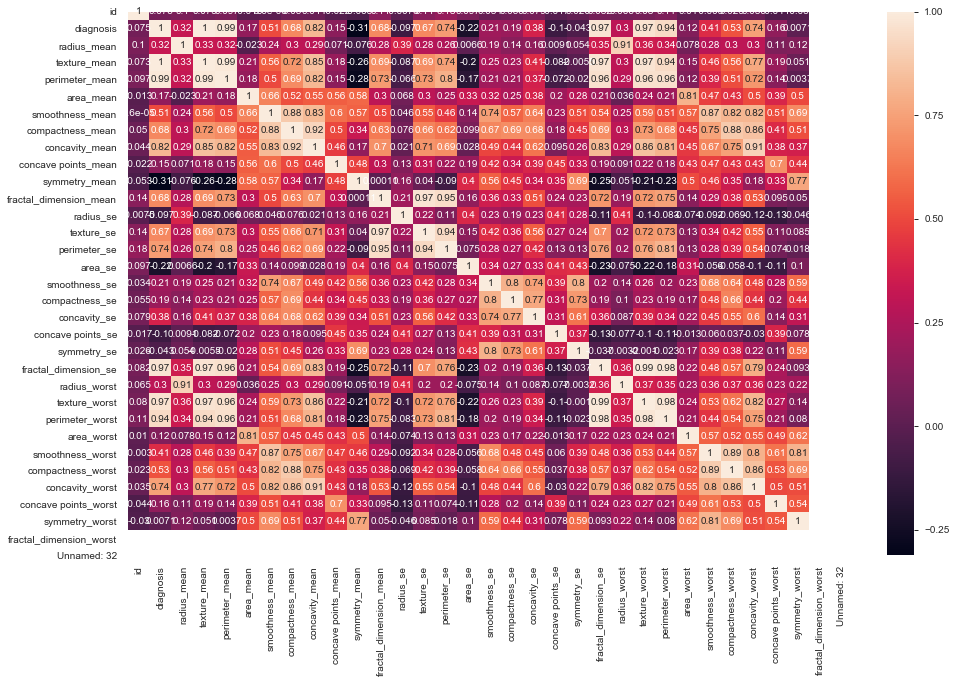

In [72]:
# plot the correlation heatmap
plt.figure(figsize=(16,10))

sns.heatmap(corr_matrix,annot=True,
        xticklabels=df.columns,
        yticklabels=df.columns)
#Correlation with output variable
cor_target = abs(df.corr()["diagnosis"])

mean_correlation = abs(X.corr()).describe().T['mean']

corr_ranking = pd.DataFrame([cor_target,mean_correlation]).T.rename(columns={"diagnosis": "target_correlation", "mean": "mean_correlation"})
corr_ranking.drop(['id','diagnosis'],axis=0,inplace=True)

In [18]:
X_ = StandardScaler().fit_transform(X)
np.set_printoptions(suppress=True)
pca = PCA()
pca = pca.fit(X_)

# summarize components
print("Explained Variance: %s" % pca.explained_variance_ratio_)

Explained Variance: [0.44272026 0.18971182 0.09393163 0.06602135 0.05495768 0.04024522
 0.02250734 0.01588724 0.01389649 0.01168978 0.00979719 0.00870538
 0.00804525 0.00523366 0.00313783 0.00266209 0.00197997 0.00175396
 0.00164925 0.00103865 0.0009991  0.00091465 0.00081136 0.00060183
 0.00051604 0.00027259 0.00023002 0.00005298 0.00002496 0.00000443]


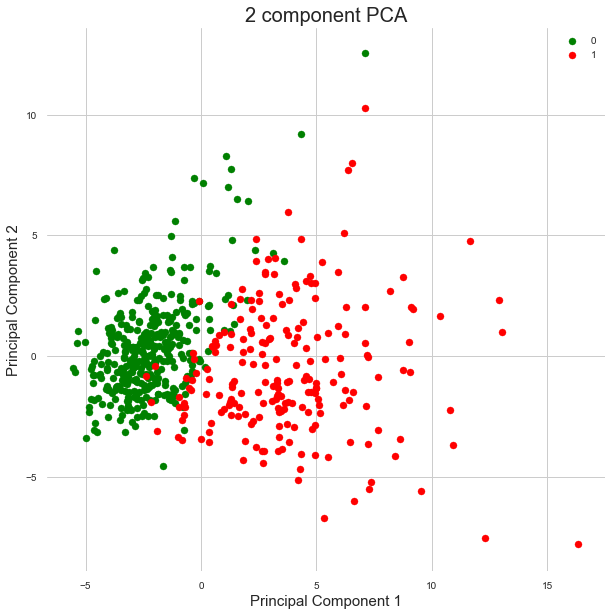

In [19]:
pca = PCA(n_components=2).fit(X_)

finalDf = pd.concat([pd.DataFrame(pca.transform(X_),columns=['principal component 1','principal component 2']), y], axis = 1)

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1]
colors = ['g', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['diagnosis'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [20]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='lbfgs')
rfe = RFE(model, 3)
fit = rfe.fit(X_, y)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
ranking_names =map(lambda x: feature_cols[x],fit.ranking_)
print("Feature Ranking: %s" % list(ranking_names))

Num Features: 3
Selected Features: [False False False False False False False False False False False False
 False False False False False False False False  True False False  True
 False False False  True False False]
Feature Ranking: ['smoothness_se', 'concavity_se', 'concave points_se', 'radius_se', 'compactness_worst', 'perimeter_se', 'compactness_se', 'compactness_mean', 'concave points_worst', 'texture_worst', 'perimeter_mean', 'smoothness_worst', 'texture_se', 'concavity_mean', 'area_worst', 'symmetry_mean', 'concavity_worst', 'fractal_dimension_se', 'perimeter_worst', 'symmetry_se', 'texture_mean', 'area_mean', 'smoothness_mean', 'texture_mean', 'fractal_dimension_mean', 'symmetry_worst', 'concave points_mean', 'texture_mean', 'area_se', 'radius_worst']


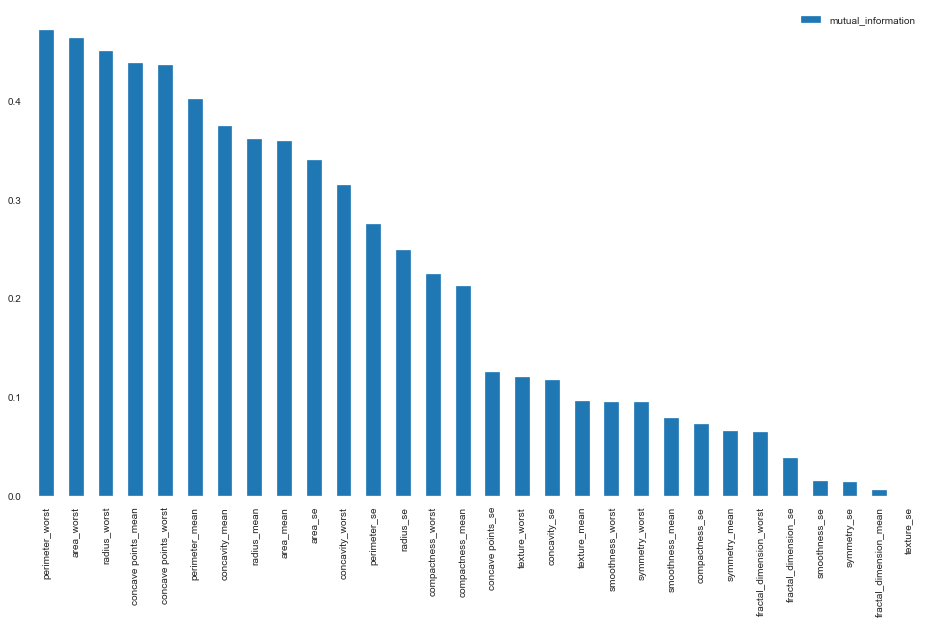

In [25]:
mutual_info = np.array(mutual_info_classif(X, y, discrete_features='auto', n_neighbors=3, copy=True, random_state=42))

mutual_info= pd.DataFrame(mutual_info,columns=["mutual_information"],index=feature_cols)

mutual_info.sort_values(by='mutual_information',ascending=False)\
        .plot(kind='bar',figsize=(16,9))

/Users/tomasztkaczyk/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


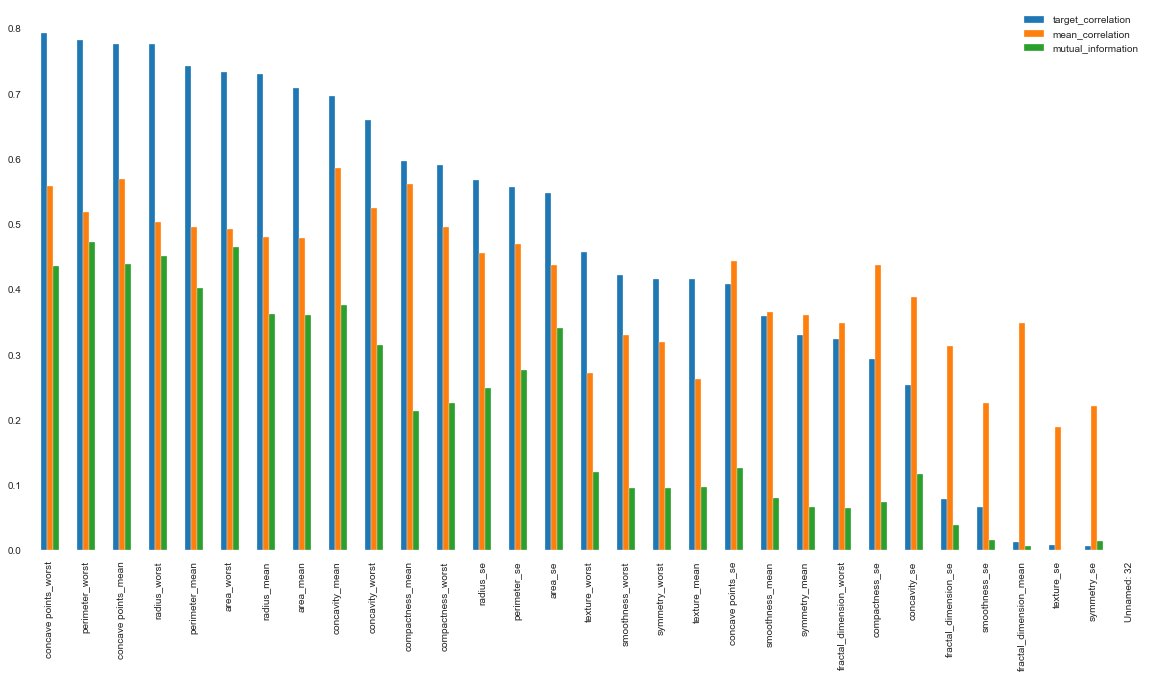

In [26]:
pd.concat([corr_ranking , mutual_info],axis=1).sort_values(by=['target_correlation','mean_correlation','mutual_information'],ascending=False).plot(kind='bar',figsize=(20,10))

In [117]:


class NumericDataCorruptor:
    def __init__(self,data,feature_stats,feature_cols):
        self.data=data
        self.feature_stats=feature_stats
        self.feature_cols = feature_cols
        
        self.probability_of_error=0.20
        
        
    def _swich_column_values(self,row,column_target):
        """This function is swiching values between two columns """
        cols = row.index.tolist()
        column_target_index = cols.index(column_target)

        if column_target_index == 0:
            column_source_index = 1
        elif column_target_index == len(cols)-1:
            column_source_index = column_target_index-1
        else:
            column_source_index = column_target_index-1
        
        column_source = cols[column_source_index]
        replace_value = row[column_source]
        print(">>> Replacing values between {}: {} and {}: {}".format(column_target,row[column_target]
                                                                ,column_source,replace_value))
        row[column_source] = row[column_target]
        row[column_target] = replace_value
        return row 
        
    def _inser_nan(self,row,column_target):
        print(">>> Replacing value with NaN")
        row[column_target]= np.nan
        return row

    def _add_noise(self,row,column_target):

        mu, sigma =self.feature_stats.loc[column_target][['mean','std']].to_numpy()
        noise = np.random.normal(row[column_target], sigma, 1)
        print('>>> Adding noise to {} => {}'.format(row[column_target],noise[0]))
        row[column_target]= noise[0]
        return row
        
        
    def _introduce_outlier(self,row,column_target):
        #print('introdice outliers')
        sigma,maximum,minimum =self.feature_stats.loc[column_target][['std','max','min']].to_numpy()
        if random.random() < 0.5:
            outlier = maximum + (random.random() * sigma)
            print('>>> Adding outliers insted of {} => {}'.format(row[column_target],outlier))
        else:
            outlier = minimum + (random.random() * sigma)
            print('>>> Adding outliers insted of {} => {}'.format(row[column_target],outlier))
        
        row[column_target] =outlier

        return row
    
    def _corrupt_column_value(self,row,col_name):
        if random.random() < self.probability_of_error:
            
            draw = choice([self._swich_column_values,
                          self._add_noise,self._inser_nan,
                          self._introduce_outlier], 1,
                          p=[0.25,0.25,0.25,.25])[0]
            return draw(row,col_name)
        else:
            return row

    
    def get_dataset_with_corrupted_col(self,col_name):
        if col_name not in self.feature_cols:
            raise ValueError("Column name is not present in the data")
        
        #assert ptypes.is_numeric_dtype(self.data[col_name])
        print('Corrutping columns:',col_name)
        self.data =self.data.apply(self._corrupt_column_value,axis=1,args=(col_name,))
        return self.data

    
data_corruptor = NumericDataCorruptor(X,feature_stats,feature_cols)
data_corruptor.get_dataset_with_corrupted_col('radius_mean')

Corrutping columns: radius_mean
>>> Replacing values between radius_mean: 15.85 and texture_mean: 23.95
>>> Adding noise to 21.16 => 16.75277918385184
>>> Adding noise to 17.14 => 20.682429716255132
>>> Replacing values between radius_mean: 18.61 and texture_mean: 20.25
>>> Replacing values between radius_mean: 11.84 and texture_mean: 18.7
>>> Replacing values between radius_mean: 19.27 and texture_mean: 26.47
>>> Adding outliers insted of 10.95 => 28.56347117692479
>>> Adding outliers insted of 13.28 => 30.01628686806285
>>> Adding outliers insted of 8.196 => 7.220101975051445
>>> Replacing value with NaN
>>> Replacing value with NaN
>>> Adding noise to 14.71 => 13.66955703147966
>>> Adding noise to 8.618 => 6.827486011081337
>>> Replacing value with NaN
>>> Replacing values between radius_mean: 14.25 and texture_mean: 22.15
>>> Adding noise to 17.2 => 15.072140225484535
>>> Adding outliers insted of 18.05 => 29.77981872265863
>>> Adding noise to 19.1 => 17.217220379786788
>>> Replaci

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.990000,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.150470,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.570000,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,2.822892,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.690000,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.059990,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.420000,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.495600,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,14.340000,20.29,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.030014,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,22.286609,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.056230,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.130000,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.055330,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.600000,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.056480,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.600000,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.726000,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400
